<a href="https://colab.research.google.com/github/ratmcu/bois/blob/master/bois.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import sys
import os
import shutil
if os.path.exists('Selfie_Filters_OpenCV') :
    shutil.rmtree('Selfie_Filters_OpenCV')
!git clone https://github.com/ratmcu/Selfie_Filters_OpenCV.git
# !conda env create -f path/to/environment.yml
!export PYTHONPATH=$PYTHONPATH:'Selfie_Filters_OpenCV'
sys.path.append('Selfie_Filters_OpenCV')
# !python test_image.py
from my_CNN_model import *
import cv2
import numpy as np
import math

Cloning into 'Selfie_Filters_OpenCV'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 79 (delta 5), reused 19 (delta 3), pack-reused 56
Unpacking objects: 100% (79/79), done.


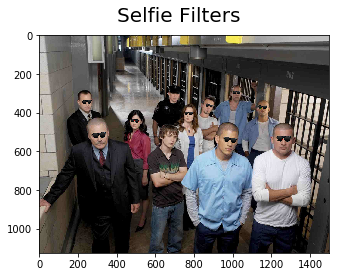

In [152]:
from my_CNN_model import *
import cv2
import numpy as np

# Load the model built in the previous step
my_model = load_my_CNN_model('Selfie_Filters_OpenCV/my_model')

# Face cascade to detect faces
face_cascade = cv2.CascadeClassifier('Selfie_Filters_OpenCV/'+'cascades/haarcascade_frontalface_default.xml')

# Define the upper and lower boundaries for a color to be considered "Blue"
blueLower = np.array([100, 60, 60])
blueUpper = np.array([140, 255, 255])

# Define a 5x5 kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)

# Define filters
filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filters = ['Selfie_Filters_OpenCV/'+filter for filter in filters]
filterIndex = 0

masks = ['bois/mask1.png', 'bois/mask2.png', 'bois/mask3.png', 'bois/mask4.png']
masks = ['Selfie_Filters_OpenCV/'+mask for mask in masks]
# [(70, 140), (115, 140)]
# [(48, 65), (93, 60)]
# [(100, 105), (140, 105)]
# [(25, 97), (68, 97)]
pivot_list = [[(70, 140), (115, 140)], [(48, 65), (93, 60)],
              [(100, 105), (140, 105)], [(25, 97), (68, 97)]]

# Load the video
# camera = cv2.VideoCapture(0)
import matplotlib.pyplot as plt
import random
import pylab

figure = pylab.figure()
figure.suptitle('Selfie Filters', fontsize=20)
# Keep looping
while True:
    # Grab the current paintWindow
#     (grabbed, frame) = camera.read()
#     frame = cv2.imread("Selfie_Filters_OpenCV/images/fn3.jpg")
    frame = cv2.imread("Selfie_Filters_OpenCV/images/bois.jpeg")
    frame = cv2.imread("Selfie_Filters_OpenCV/images/test.jpg")

#     frame = cv2.imread("fn3.jpg")
    img_bg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.flip(frame, 1)
    img_bg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame2 = np.copy(frame)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add the 'Next Filter' button to the frame
    frame = cv2.rectangle(frame, (500,10), (620,65), (235,50,50), -1)
    cv2.putText(frame, "NEXT FILTER", (512, 37), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)
    for (x, y, w, h) in faces:
        # Grab the face
        gray_face = gray[y:y+h, x:x+w]
        color_face = frame[y:y+h, x:x+w]

        # Normalize to match the input format of the model - Range of pixel to [0, 1]
        gray_normalized = gray_face / 255

        # Resize it to 96x96 to match the input format of the model
        original_shape = gray_face.shape # A Copy for future reference
        face_resized = cv2.resize(gray_normalized, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_copy = face_resized.copy()
        face_resized = face_resized.reshape(1, 96, 96, 1)

        # Predicting the keypoints using the model
        keypoints = my_model.predict(face_resized)

        # De-Normalize the keypoints values
        keypoints = keypoints * 48 + 48

        # Map the Keypoints back to the original image
        face_resized_color = cv2.resize(color_face, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_color2 = np.copy(face_resized_color)

        # Pair them together
        points = []
        for i, co in enumerate(keypoints[0][0::2]):
            points.append((co, keypoints[0][1::2][i]))

        # read the filter
        sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
        pivot_points = [(40, 30), (140, 30)]
#         cv2.circle(img_bg, (200, 200), 10, (0,255,0), -1)
        detected_points = [(int(points[1][0]*h/96+x), int(points[1][1]*w/96+y)), 
                           (int(points[0][0]*h/96+x), int(points[0][1]*w/96+y))]
        img_bg = paste_mask(detected_points, pivot_points, sunglasses, img_bg)
#         face_resized_color = paste_mask([(int(points[1][0]+y), int(points[1][1]+x)), (int(points[0][0]+y), int(points[0][1]+x))], pivot_points, sunglasses, img_bg)
#         pylab.imshow(img_bg)
#         face_resized_color = cv2.cvtColor(face_resized_color, cv2.COLOR_BGR2RGB)
        # fill the area relavant to the frame on the bigger image
#         img_bg[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)
#         cv2.circle(img_bg, (int(points[1][0]+y), int(points[1][1]+x)), 1, (0,255,0), 1)
#         cv2.circle(face_resized_color, points[0], 1, (0,255,0), 1) #right eye
#         cv2.circle(face_resized_color, points[1], 1, (0,255,0), 1) #left eye
#         img_bg[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)
#         break
    break
pylab.imshow(img_bg)
# pylab.show()

In [0]:
def paste_mask(detected, pivots, mask, face):
#     figure = pylab.figure()
#     figure.suptitle('face', fontsize=20)
#     cv2.circle(face, detected[0], 10, (255,0,0), -1)
#     cv2.circle(face, detected[1], 10, (0,0,255), -1)
#     pylab.imshow(face)
#     return face
#     cv2.circle(face, detected[0], 1, (0,255,0), 1)
#     cv2.circle(face,  detected[1], 1, (0,255,0), 1)
    scale = math.sqrt((detected[1][1]-detected[0][1])*(detected[1][1]-detected[0][1]) + 
                    (detected[1][0]-detected[0][0])*(detected[1][0]-detected[0][0]))/math.sqrt((pivots[1][1]-pivots[0][1])*(pivots[1][1]-pivots[0][1]) +
                              ((pivots[1][0]-pivots[0][0])*(pivots[1][0]-pivots[0][0])))
    angle = (math.atan2((detected[0][1]-detected[1][1]), -(detected[0][0]-detected[1][0]))*(180))/math.pi
    rows, cols, channels = mask.shape
#     print(rows, cols, channels)
    dr = rows - pivots[0][1]
    dc = cols - pivots[0][0]
    hyp = int(math.sqrt(dr*dr + dc*dc))
    # print(rows, cols, hyp)
    # add the borders so the rotation won't clip any of the mask 
    top    = int(hyp-pivots[0][0])  #
    bottom = int(hyp-rows+pivots[0][1])
    left   = int(hyp-pivots[0][1])  # shape[1] = cols
    right  = int(hyp-(cols-pivots[0][0]))
#     print(scale)
    value = [0, 0, 0]
    borderType = cv2.BORDER_CONSTANT
    mask_resized = cv2.copyMakeBorder(mask, top, bottom, left, right, borderType, None, value)
#     figure = pylab.figure()
#     figure.suptitle('bordered', fontsize=20)
#     pylab.imshow(mask_resized)

    # rotate the mask inside the safely resized canvas
    bordered_dim = mask_resized.shape
    M = cv2.getRotationMatrix2D((pivots[0][0]+left, pivots[0][1]+top), angle, 1)
    mask_resized = cv2.warpAffine(mask_resized, M, (int(bordered_dim[1]), int(bordered_dim[0])))

    # resize the mask to match the scaling of the seperation between the face
    sunglass_width = int((bordered_dim[0])*scale)
    sunglass_height = int((bordered_dim[1])*scale)
    mask_resized = cv2.resize(mask_resized, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
#     print(mask_resized.shape)
#     figure = pylab.figure()
#     figure.suptitle('resized', fontsize=20)
#     cv2.circle(mask_resized, pivots[1], 1, (0,0,255), 1)
    # cv2.circle(mask_resized, (20, 20), 1, (0,0,255), 1)
    new_eyes = pivots.copy()
    # print(new_eyes[0][0])
    new_eyes[0] = list(new_eyes[0])
    new_eyes[1] = list(new_eyes[1])
    new_eyes[0][0] = pivots[0][0]+top
    new_eyes[0][1] = pivots[0][1]+left
#     cv2.circle(mask_resized,  pivots[0], 1, (255,0,0), -1)
#     pylab.imshow(mask_resized)
    transparent_region = mask_resized[:,:,:3] != 0
    #adding the sunglasses to the face
    # find the pixel position of the mask canvas to start on the face and fill the face
    start_point_row = int(detected[0][1]-int(new_eyes[0][1]*scale))
    start_point_col = int(detected[0][0]-int(new_eyes[0][0]*scale))
    face[start_point_row:start_point_row+sunglass_height, 
                    start_point_col:start_point_col+sunglass_width,:][transparent_region] = mask_resized[:,:,:3][transparent_region]
#     cv2.circle(face, detected[0], 1, (0,255,0), 1)
#     cv2.circle(face,  detected[1], 1, (0,255,0), 1)
    return face

<Figure size 432x288 with 0 Axes>

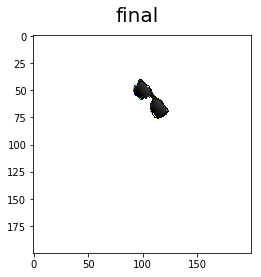

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filters = ['Selfie_Filters_OpenCV/'+filter for filter in filters]
filterIndex = 0

figure = pylab.figure()
figure.suptitle('points test', fontsize=20)
# detected_eyes = [(100, 50), (120, 70)]
detected_eyes = [(100, 50), (120, 70)]
original_eyes = [(40, 30), (140, 30)]
# original_eyes = [(40, 30), (140, 30)]

size = 200, 200, 3
m = np.ones(size, dtype=np.uint8)*255
# m = cv2.cvtColor(m, cv2.COLOR_RGB2RGBA)
# print(m.shape)
# cv2.circle(m, (20,50), 1, (0,255,0), 1)
sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
m = paste_mask(detected_eyes, original_eyes, sunglasses, m)
figure = pylab.figure()
figure.suptitle('final', fontsize=20)
pylab.imshow(m)

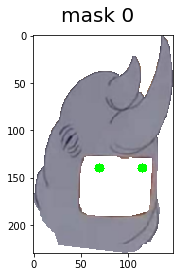

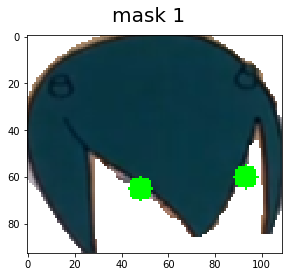

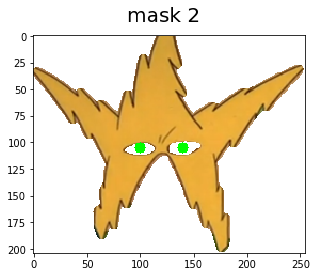

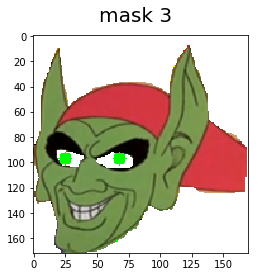

In [151]:
#experiment_code
#mask testing code
masks = ['bois/mask1.png', 'bois/mask2.png', 'bois/mask3.png', 'bois/mask4.png']
masks = ['Selfie_Filters_OpenCV/'+mask for mask in masks]
# [(70, 140), (115, 140)]
# [(48, 65), (93, 60)]
# [(100, 105), (140, 105)]
# [(25, 97), (68, 97)]
pivot_list = [[(70, 140), (115, 140)], [(48, 65), (93, 60)],
              [(100, 105), (140, 105)], [(25, 97), (68, 97)]]
for i, mask in enumerate(masks):
    mask_img_alpha = cv2.imread(mask, cv2.IMREAD_UNCHANGED)
    figure = pylab.figure()
    figure.suptitle('mask {0}'.format(i), fontsize=20)
    mask_img_color = cv2.cvtColor(mask_img_alpha[:,:,:4], cv2.COLOR_BGR2RGB)
    rows, cols, channels = mask_img_alpha.shape
    mask_img_rgba = cv2.cvtColor(mask_img_color, cv2.COLOR_RGB2RGBA)
    for row in range(0,rows):
        for col in range(0,cols):
            if mask_img_alpha[row,col,3] == 0:
#                 patch[row,col,:] = (255, 0, 0, 0)
                mask_img_rgba[row,col,:] = (0, 0, 0, 0)
#     mask_img2[:,:,:3] = mask_img[:,:,:3][transparent_region]
#     mask_img2 = cv2.cvtColor(mask_img2[:,:,:4], cv2.COLOR_BGR2RGB)
    cv2.circle(mask_img_rgba, pivot_list[i][0], 5, (0, 255, 0, 255), -1)
    cv2.circle(mask_img_rgba, pivot_list[i][1], 5, (0, 255, 0, 255), -1)
    pylab.imshow(mask_img_rgba)